# Load the Data

* Reads several log files.
* Identifies users with complete data across key logs.
* Creates dedicated directories for each of these users.
* Saves user-specific logs into these directories for further analysis.

The main goal of this script is to segregate and prepare the raw log data by user. This is often a preliminary step in data processing pipelines, especially when the subsequent analysis (like behavioral analysis or anomaly detection) needs data organized on a per-user basis.



In [1]:
import pandas as pd
import os
import shutil

device_file_path = '/Users/macos/Desktop/memoire/r4.2/device.csv'
email_file_path = '/Users/macos/Desktop/memoire/r4.2/email.csv'
http_file_path = '/Users/macos/Desktop/memoire/r4.2/http.csv'
file_file_path = '/Users/macos/Desktop/memoire/r4.2/file.csv'
logon_file_path = '/Users/macos/Desktop/memoire//r4.2/logon.csv'

device_df = pd.read_csv(device_file_path)
email_df = pd.read_csv(email_file_path)
http_df = pd.read_csv(http_file_path)
file_df = pd.read_csv(file_file_path)
logon_df = pd.read_csv(logon_file_path)

output_dir = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data'
os.makedirs(output_dir, exist_ok=True)

# Specify the users explicitly
users_with_all_files = ['EDB0714', 'HXL0968', 'TNM0961']

for user in users_with_all_files:
    user_dir = os.path.join(output_dir, str(user))
    if not os.path.exists(user_dir):
        os.makedirs(user_dir)
    pd.DataFrame(device_df[device_df['user'] == user]).to_csv(os.path.join(user_dir, 'device.csv'), index=False)
    pd.DataFrame(email_df[email_df['user'] == user]).to_csv(os.path.join(user_dir, 'email.csv'), index=False)
    pd.DataFrame(http_df[http_df['user'] == user]).to_csv(os.path.join(user_dir, 'http.csv'), index=False)
    pd.DataFrame(file_df[file_df['user'] == user]).to_csv(os.path.join(user_dir, 'file.csv'), index=False)
    pd.DataFrame(logon_df[logon_df['user'] == user]).to_csv(os.path.join(user_dir, 'logon.csv'), index=False)


In summary, this code is used to identify and display the names of all users (i.e., the subdirectories) that exist in the specified output directory.

In [2]:
import os

output_dir = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data'

user_directories = [d for d in os.listdir(output_dir) if os.path.isdir(os.path.join(output_dir, d))]
user_names = user_directories
print("User names existing in the output folder:")
print(user_names)

User names existing in the output folder:
['TNM0961', 'EDB0714', 'HXL0968']


This effectively provides a quick reference for which machine (or PC) is linked to each user based on the device logs.

In [3]:
user_machines = {}

for user in user_names:
    user_machine = device_df.loc[device_df['user'] == user, 'pc'].iloc[0]
    user_machines[user] = user_machine
print(user_machines)


{'TNM0961': 'PC-2030', 'EDB0714': 'PC-6103', 'HXL0968': 'PC-0623'}


In [4]:
length = len(user_machines)
print("Length of user_machines dictionary: :", length)

Length of user_machines dictionary: : 3


# Feature Extraction 

Two main Processes happened in the Feature extraction:

* Processes diGerent types of logs (logon, device, email, HTTP) to compute diGerent
features for example connection durations, number of logins, device usage counts,
email statistics, and web browsing behaviors.

* Combines actions from diGerent logs into ordered daily sequences, sorts these
actions by time, and converts them into numerical codes

In [5]:
from datetime import datetime
import numpy as np
import os
data_set={0:'logon.csv',1:'device.csv',2:'email.csv',3:'http.csv',4:'file.csv'}

def path_check(path):
    folders=os.path.exists(path)
    if not folders:
        print("Create new folders: ' %s ' successfully!"%(path))
        os.makedirs(path)
    else:
        print("The folder  ' %s ' exits, Some data will be rewrited !"%(path))
        pass

def new_log(file_in,file_out):
    """delete the id in the first column
    """
    file_in=open(file_in,'r')
    file_out=open(file_out,'wt')
    for line in file_in:
        line=line.split(',')
        if MACHINE in line:
            newline=','.join(line[1:])
            file_out.writelines(newline)
    file_in.close()

def combine_time_log(file_in,file_out):
    """combine data within the same day
    """
    files_in=open(file_in,'r')
    date_set=['null']
    for line in files_in:
        line=line.split(' ')
        if line[0] not in date_set:
            date_set.append(line[0])
                # print (date_set)
    files_in.close()

    i=0
    files_in=open(file_in,'r')
    files_out=open(file_out,'wt')
    newline=''
    for line in files_in:
        line=line.strip()
        line=line.replace(' ',',')
        if date_set[i] in line:
            newline=newline+' ; '+line
        else:
            files_out.writelines(newline+'\n')
            newline=line
            i=i+1

def find_weekday(time):
    """ Time: for example, 04/01/2010
Returns:
 Day of the week: 1: Monday 2: Tuesday ...
    """
    week=datetime.strptime(time,'%m/%d/%Y').weekday()+1
    return (week)

def count_time(time_logon,time_logoff):
    """Count the connection time
time_longon: for example, 07:20:00
time_logoff: for example, 15:20:00
return:
last_time: float, the number of hours connected.
    """
    time_logon=datetime.strptime(time_logon,'%H:%M:%S')
    time_logoff=datetime.strptime(time_logoff,'%H:%M:%S')
    last_time=(time_logoff-time_logon).total_seconds()/3600
    last_time=round(last_time,2)
    return last_time
    # print(last_time)

# ----------------- (features for different logs of a user)：)：
def log_feature(file_input):
    files_in=open(file_input,'r')
    data_dicts={}
    m=1
    for line in files_in:
         # print (m)
        m=m+1
        if line !='\n':
            line=line.strip()
            time_line=line.split(',')
            week_time=time_line[0] # format: 01/04/2010
            weekday=find_weekday(week_time)
            # ----- Le nombre total de machines de connexion
            computer_number=1
            computer_id=1
            # -----(nombre de connexions en un jour)
            numebr_logon=line.count('Logon')
            #
            line=line.split(' ; ')
            # -----  (la première fois de connexion)
        if len(line) >= 2:
            first_logon=line[0].split(',')[1] # format: 07:20:00
            first_logoff=line[1].split(',')[1]
            first_logon_time=datetime.strptime(first_logon,'%H:%M:%S')
            first_logoff_time=datetime.strptime(first_logoff,'%H:%M:%S')
            first_logon_hour=first_logon_time.hour
            first_logon_minutes=first_logon_time.minute
            first_logoff_hour=first_logoff_time.hour
            first_logoff_minutes=first_logoff_time.minute
            # print(first_logoff_hour)

            # ----- (la dernière fois de connexion)
            last_logon=line[-2].split(',')[1]
            last_logoff=line[-1].split(',')[1]
            last_logon_time=datetime.strptime(last_logon,'%H:%M:%S')
            last_logoff_time=datetime.strptime(last_logoff,'%H:%M:%S')
            last_logon_hour=last_logon_time.hour
            last_logon_minutes=last_logon_time.minute
            last_logoff_hour=last_logoff_time.hour
            last_logoff_minutes=last_logoff_time.minute
            # print(last_logoff_hour)

            # ----(la durée d'une connexion = dernière déconnexion - première connexion)
            online_time=count_time(first_logon,last_logoff)
            data_list=[numebr_logon,first_logon_hour,first_logon_minutes,first_logoff_hour,first_logoff_minutes,last_logon_hour,last_logon_minutes,last_logoff_hour,last_logoff_minutes,online_time]
            data_dicts[week_time]=data_list
            #
    # file_output.writelines(str(data_dicts))
    files_in.close()
    # file_output.close()
    return data_dicts

def device_feature(file_input,log_dicts):
    files_in=open(file_input,'r')
    m=0
    for line in files_in:
        if line !='\n':
            line=line.strip()
            time_line=line.split(',')
            week_time=time_line[0] # format: 01/04/2010
            weekday=find_weekday(week_time)
            # ----- (nombre de machines qui ont été connectées à des appareils)
            computer_number=1
            # ----------------------- (la première machine, en une journée)---------------------------
            computer_id=1
            # ----- (combien de fois j'utilise des appareils dans cette machine)
            numebr_use_device=line.count('Connect')
            data_device=[numebr_use_device]
            if week_time in log_dicts:
                    log_dicts[week_time] = log_dicts[week_time] + data_device
            else:
                    log_dicts[week_time] = data_device

             # print (log_dicts[week_time])
            # exit(0)
    files_in.close()
    return log_dicts

def email_feature(file_input,http_dicts):
    files_in=open(file_input,'r')
    for line in files_in:
        if line !='\n':
            line=line.strip()
            time_line=line.split(',')
            week_time=time_line[0] # format: 01/04/2010
            weekday=find_weekday(week_time)
            #
            line=line.split(' ; ')
            # ----- (number de emailing)：
            Number_email=len(line)
            #
            data_email=[]
            for i in range(len(line)):
                eamil_set=[]
                new_line=line[i].replace(';',',')
                new_line=new_line.split(',')
                for string in new_line:
                    # print(string)
                    if '@' in string and (string not in eamil_set):
                        eamil_set.append(string)
                # ----- Nombre de personnes recevant des e-mails à chaque fois :
                Number_receiver=len(eamil_set)-1
                # Email de l'expéditeur :
                source_email=eamil_set[-1]
                # -----Chaque fois que l'e-mail de l'expéditeur est un e-mail personnel ou d'entreprise
                if '@dtaa.com' in source_email:
                    source_email_type=0
                else:
                    source_email_type=1
                receiver_email=eamil_set[:-1]
                Number_company_email=0
                for address in receiver_email:
                    if '@dtaa.com' in address:
                        Number_company_email+=1
                # ----- L'adresse e-mail de chaque destinataire correspond au nombre d'adresses e-mail de l'entreprise.
                # ----- Le nombre de boîtes aux lettres privées pour la boîte aux lettres de chaque destinataire
                Number_private_email=Number_receiver-Number_company_email
                #  Valeur d'index de l'adresse email de l'expéditeur (première occurrence)
                source_email_index=new_line.index(source_email)
                # Valeur d'index de la taille du message
                size_index=source_email_index
                while not new_line[size_index].isdigit():
                    size_index=size_index+1
                # ----- Taille de chaque message: （KB）
                size_email=round(float(new_line[size_index])/1024,2)
                # Valeur d'index de la valeur de pièce jointe
                attachment_index=size_index+1
                # ----- Nombre de pièces jointes par fois:
                attachment_count=int(new_line[attachment_index])
                data_email=data_email+[Number_receiver,source_email_type,Number_company_email,Number_private_email,size_email,attachment_count]
            # print(len(data_email[:24]))
            if week_time in http_dicts:
              http_dicts[week_time] = http_dicts[week_time] + [Number_email] + data_email[:24]
            else:
             http_dicts[week_time] = [Number_email] + data_email[:24]

    files_in.close()
    # print(log_dicts)
    return http_dicts

def file_feature(file_input):
    files_in=open(file_input,'r')
    for line in files_in:
        if line !='\n':
            line=line.strip()
            time_line=line.split(',')
            week_time=time_line[0] # format: 01/04/2010
            weekday=find_weekday(week_time)
            # Nombre de fois où le fichier a été consulté
    files_in.close()

def http_feature(file_input,device_dicts):
    """ network feature
    """
    files_in=open(file_input,'r')
    for line in files_in:
        if line !='\n':
            line=line.strip()
            time_line=line.split(',')
            week_time=time_line[0] # format: 01/04/2010
            weekday=find_weekday(week_time)
            #
            line=line.split(' ; ')
            # ----- ( number de web browsing )
            Numeber_webs=len(line)
# ----------------browsing information on web pages at different times)---------------
            time_sets=[]
            time_hour_sets=[]
            for i in range(Numeber_webs):
             new_line=line[i]
             new_line=new_line.split(',')
             time_line=new_line[1]
             time_sets.append(time_line)
             for each_time in time_sets:
                 time_hour=datetime.strptime(each_time,'%H:%M:%S').hour
                 time_hour_sets.append(time_hour)
# -------- (Recording web page browsing at different times will provide useful information to simulate a user's habit in browsing web pages. And it will be helpful to detect illegal logins.)
            #--8:00
            time_brefore=time_hour_sets.count(7)+time_hour_sets.count(6)+time_hour_sets.count(5)+time_hour_sets.count(4)
            # # 8-9
            time_One=time_hour_sets.count(8)
            # # 9-10
            time_Two=time_hour_sets.count(9)
            # # 10-11
            time_Three=time_hour_sets.count(10)
            # # 11-12
            time_Four=time_hour_sets.count(11)
            # # 12-13
            time_Five=time_hour_sets.count(12)
            # # 13-14
            time_Six=time_hour_sets.count(13)
            # # 14-15
            time_Seven=time_hour_sets.count(14)
            # # 15-16
            time_Eight=time_hour_sets.count(15)
            # # 16-17
            time_Nine=time_hour_sets.count(16)
            # # 17-18
            time_Ten=time_hour_sets.count(17)
            # # 18-19
            time_Eleven=time_hour_sets.count(18)
            # # 19:00 --
            time_Twelve=time_hour_sets.count(19)+time_hour_sets.count(20)+time_hour_sets.count(21)+time_hour_sets.count(22)+time_hour_sets.count(23)
            # --------------------------------------------------------------------

            # print (time_hour_sets)
            # print(time_Four)
            data_http=[Numeber_webs]
            default_length = 11  # Adjust this based on the expected initial list length
            if week_time not in device_dicts:
             device_dicts[week_time] = [0] * default_length
             device_dicts[week_time] = device_dicts[week_time] + data_http

    files_in.close()
    return device_dicts
            # exit(0)

def dict_complemetion(dicts,set_length):
    for (key,value) in dicts.items():
        while len(value)<set_length:
            value.append(0)
    return dicts

def mix_complemention(dicts,columns,set_length):
    """
    Unify the data dimensions of the input dicts. There are two lists in the dicts value. When columns=0, the first list is used; when columns=1, the second list is used.
    """
    for (key,value) in dicts.items():
        while len(value[columns])<set_length:
            value[columns].append(0)
    return dicts

# ---------------------------- temp
def list_complemetion(lists,set_length):
    while len(lists)<set_length:
        lists.append(0)
    return lists

def file_sequence(file_in,file_type):
    """
   Generate sequence based on date
file_in:
file_type: int (0-4, 0: connection, 1: device, 2: email, 3: file, 4: http)
Returns:
A sequence dictation, key: date; value: actions and time.
    """

    type_set={0:'logon', 1:'device', 2:'email', 3:'file', 4:'http'}
    type_words=type_set[file_type]
    files_in=open(file_in,'r')
    sequences_set={}
    for line in files_in:
        if line !='\n':
            line=line.split(' ; ')
            # print (len(line))
            for records in line:
                if file_type==0 and 'Logon'in records:
                    type_words= 'logon'
                elif file_type==0 and 'Logoff'in records:
                    type_words= 'logoff'
                if file_type==1 and 'Connect' in records:
                    type_words= 'Connect'
                elif file_type==1 and 'Disconnect' in records:
                    type_words='Disconnect'
                records=records.split(',')
                if records[0] in sequences_set:
                    values=records[1]+'#'+type_words
                    sequences_set[records[0]]=sequences_set[records[0]]+' & '+values
                else:
                    values=records[1]+'#'+type_words
                    sequences_set[records[0]]=values
    files_in.close()
    return(sequences_set)

def sequence_combine(sequence_one,sequence_two):
    """
combine two sequence dicts based on key (date). Arg: sequence one: dicts sequence two: dicts Return: a combined dict.    """

    for (date,record) in sequence_two.items():
        if date in sequence_one:
            new_record=sequence_one[date]+' & '+record
            sequence_one[date]=new_record
        else:
            print ('some date missed! Please change the combination order')
            exit(0)
        # print(sequence_one)
        # exit(0)
    return(sequence_one)

def sort_actions_One_Day(Day_records):
    """
    Sort the actions in A Day in Time.

Day_records: A string composed of times and actions (08:56:00#logon & 17:05:00#logoff...)
Returns: A string of sorted action sequences.
    """
    line=Day_records.split(' & ')
    length=len(line)
    actions_dict={}
    time_dict=[]
    actions_sorted=[]
    for temp_data in line:
        # # temp_data[0:8] is time data, temp_data[9:] is behavioral data, and the "#" symbol is removed in the middle
        actions_dict[temp_data[0:8]]=temp_data[9:]
        time_dict.append(temp_data[0:8])
    time_sorted=quick_sort_datetime(time_dict)
    for time_string in time_sorted:
        actions_sorted.append(actions_dict[time_string])
    action_sequence=','.join(actions_sorted)
    return action_sequence,length

user_max_length = {}

def sort_actions_InSequence(sequence_in,save_file):
    """
sort the actions day by day in the dict over time. Arg: sequence in: a dict (the unordered sequence) Return: a dict (the ordered sequence)    """
    files=open(save_file,'wt')
    max_length=0
    for (date,records) in sequence_in.items():
        actions_sequence,day_actions_length=sort_actions_One_Day(records)
        files.writelines(date+' : '+actions_sequence+'\n')
        if day_actions_length>max_length:
            max_length=day_actions_length
            # Update the global dictionary

    user_max_length[username] = max_length
    print(f"{username}_maxlength: {max_length}")
    return max_length

def quick_sort(array):
    """
    quick sort algorithm
         array: a list
        Return: a list

    """
    smaller_list=[]
    bigger_list=[]
    equal_list=[]
    if len(array)<=1:
        return array
    else:
        middle_key=array[0]
        for records in array:
            if records < middle_key:
                smaller_list.append(records)
            elif records > middle_key:
                bigger_list.append(records)
            else:
                equal_list.append(records)
        smaller_list=quick_sort(smaller_list)
        bigger_list=quick_sort(bigger_list)
        return smaller_list+equal_list+bigger_list

def quick_sort_datetime(array):
    """
   Quick sort algorithm for the datetime class.
Arg:
array: a list (elements belong to the datetime class)
Returns: a list (elements belong to a string)
    """
    smaller_list=[]
    bigger_list=[]
    equal_list=[]
    if len(array)<=1:
        return array
    else:
        middle_key=datetime.strptime(array[0],'%H:%M:%S')
        for records in array:
            datetime_records=datetime.strptime(records,'%H:%M:%S')
            if datetime_records < middle_key:
                smaller_list.append(records)
            elif datetime_records > middle_key:
                bigger_list.append(records)
            else:
                equal_list.append(records)
        smaller_list=quick_sort(smaller_list)
        bigger_list=quick_sort(bigger_list)
        return smaller_list+equal_list+bigger_list

def sequence_code(sequence_files_in,sequence_code_save,sequence_len):

    code_dict={'logon':1,'Connect':2,'Disconnect':3,'http':4,'email':5,'logoff':6}
    file_in=open(sequence_files_in,'r')
    file_out=open(sequence_code_save,'wt')
    file_out.close()
    file_out=open(sequence_code_save,'a+')
    for line in file_in:
        line=line.strip()
        line=line.split(' : ')
        week_day=find_weekday(line[0])
        sequences=line[1].split(',')
        sequence_codes=[]
        for actions in sequences:
            sequence_codes.append(code_dict[actions])
        sequence_codes=list_complemetion(sequence_codes,sequence_len)
        sequence_codes=np.reshape(sequence_codes,(1,sequence_len))
        np.savetxt(file_out,sequence_codes,fmt='%f',delimiter=',')
    file_out.close()

# --------- preprocessing (logon.csv, device.csv ...)
def pre_step():
    """
   data preprocessing
    """
    path='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/new'
    path_check(path)
    filetype=['/http.csv','/device.csv','/email.csv','/file.csv','/http.csv','/logon.csv']
    for type_num in range (len(filetype)):
        new_log('/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+filetype[type_num],path+filetype[type_num])

    # step 2  ----------- combine data in the same day
    new_filename=['/http2.csv','/device2.csv','/email2.csv','/file2.csv','/http2.csv','/logon2.csv']
    for type_num in range (len(filetype)):
        file_in='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/new'+filetype[type_num]
        file_out='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/new'+new_filename[type_num]
        combine_time_log(file_in,file_out)

# ----------- feature generating
def Feature_generate(file_in,file2_in,file3_in,file4_in):
    """
    Generate features for every user
    """
    path_feature='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/feature'
    path_check(path_feature)
    file_out='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/feature/data_out.csv'
    log_dicts=log_feature(file_in)
    device_dicts=device_feature(file2_in,log_dicts)
    new_device_dicts=dict_complemetion(device_dicts,11)
    http_dicts=http_feature(file4_in,new_device_dicts)
    new_http_dicts=dict_complemetion(http_dicts,12)
    email_dicts=email_feature(file3_in,new_http_dicts)
    new_email_dicts=dict_complemetion(email_dicts,37)
    # (empty the file)
    data_save=open(file_out,'wt')
    data_save.close()
    #  (save data )
    data_save=open(file_out,'a+')
    for (key,value) in new_email_dicts.items():
        # print (len(value))
        values=np.reshape(value,(-1,37))
        np.savetxt(data_save,values,fmt='%f',delimiter=',')
    data_save.close()

#-------------------------------------------
def Sequence_generate(file_in,file2_in,file3_in,file4_in):
    """
Generate action sequences pour every user
    """
    path='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/sequence'
    path_check(path)
    ActionSeq_save_path='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/sequence/actions_sequence.csv'
    sequence_temp='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/sequence/sequence_temp.csv'
    sequence_code_save='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/sequence/sequence_code.csv'

    logon_time_sequence=file_sequence(file_in,0)
    device_time_sequence=file_sequence(file2_in,1)
    email_time_sequence=file_sequence(file3_in,2)
    http_time_sequence=file_sequence(file4_in,4)

    Final_Sequence=sequence_combine(logon_time_sequence,device_time_sequence)
    Final_Sequence=sequence_combine(Final_Sequence,email_time_sequence)
    Final_Sequence=sequence_combine(Final_Sequence,http_time_sequence)
    max_length=sort_actions_InSequence(Final_Sequence,ActionSeq_save_path)

    file_temp=open(sequence_temp,'wt')
    file_temp.writelines(str(Final_Sequence))
    file_temp.close()
    # -------------- sequence code
    sequence_code(ActionSeq_save_path,sequence_code_save,max_length)

    # --------------------------


if __name__ == "__main__":

    for username,machine in user_machines.items():
        USERNAME=username
        MACHINE=machine

        print(USERNAME)
        file_in='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/new/logon2.csv'
        file2_in='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/new/device2.csv'
        file3_in='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/new/email2.csv'
        file4_in='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/new/http2.csv'

        # preprocessing
        pre_step()
        # générer la fonctionnalité pour les comportements quotidiens.
        Feature_generate(file_in,file2_in,file3_in,file4_in)
        # générer les données de séquence pour les séquences d'actions quotidiennes.
        Sequence_generate(file_in,file2_in,file3_in,file4_in)



TNM0961
Create new folders: ' /Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/TNM0961/new ' successfully!
Create new folders: ' /Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/TNM0961/feature ' successfully!
Create new folders: ' /Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/TNM0961/sequence ' successfully!
TNM0961_maxlength: 32
EDB0714
Create new folders: ' /Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/EDB0714/new ' successfully!
Create new folders: ' /Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/EDB0714/feature ' successfully!
Create new folders: ' /Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/EDB0714/sequence ' successfully!
EDB0714_maxlength: 29
HXL0968
Create new folders: ' /Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/HXL0968/new ' successfully!
Create new folders: ' /Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/HXL0968/feature ' successfully!
Create new folders: ' /Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/HXL0968/sequence ' s

In [6]:
user_max_length

{'TNM0961': 32, 'EDB0714': 29, 'HXL0968': 33}

# Prepare sequential data

Here the data will be generated and splitted ("Feature Map" or "Action Sequence"):
* It reads a file containing either feature maps or action sequences and aggregates
consecutive lines (four days of data are combined as input and the fifth day is used
as the label). This is done in batches, converting the text into numerical arrays
* Once the aggregated input label pairs are generated and also saved, the code will be
splitting the complete dataset into training and testing sets based on a specific ratio

In [7]:
import numpy as np
import linecache
import os

def path_check(path):

    folders=os.path.exists(path)
    if not folders:
        print("Create new folders: ' %s ' successfully!"%(path))
        os.makedirs(path)
    else:
        print("The folder  ' %s ' exits, Some data will be rewrited !"%(path))
        pass

def count_line(files_in):
    file_open=open(files_in,'r')
    count=0
    for line in file_open:
        count+=1
    return count

def data_generator(files_name,num_days=5):
    # Delete the last row of data as there may be gaps
    counts=count_line(files_name)-1
    real_counts=counts-num_days+1
    print (real_counts)
    for i in range(real_counts):
        data_index=i+1
        label_index=data_index+4
        data_one=np.array(linecache.getline(files_name,data_index).strip().split(',')+linecache.getline(files_name,data_index+1).strip().split(',')+linecache.getline(files_name,data_index+2).strip().split(',')+linecache.getline(files_name,data_index+3).strip().split(','))
        labe_data=np.array(linecache.getline(files_name,label_index).strip().split(','))
        # exit (0)
        yield (data_one,labe_data)

types='FeatureMap'
def type_check():
    if types=='FeatureMap':
        files_name='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/feature/data_out.csv'
        data_all='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/feature/data_all.csv'
        label_all='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/feature/label_all.csv'
        data_train='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/feature/data_train.csv'
        data_test='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/feature/data_test.csv'
        label_train='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/feature/label_train.csv'
        label_test='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/feature/label_test.csv'
    else:
        files_name='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/sequence/sequence_code.csv'
        data_all='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/sequence/data_all.csv'
        label_all='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/sequence/label_all.csv'
        data_train='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/sequence/data_train.csv'
        data_test='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/sequence/data_test.csv'
        label_train='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/sequence/label_train.csv'
        label_test='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/sequence/label_test.csv'

# étape 1 ------------------------------------ generate data over several days
def data_clean(data_all,label_all):
    data_save=open(data_all,'wt')
    label_save=open(label_all,'wt')
    data_save.close()
    label_save.close()
def generate_data(data_all,label_all,files_name):
    ''' We extract all five data points from our dataset.
The first four data points are used as input data,
and the fifth data point is used as a label. '''
    data_save=open(data_all,'a+')
    label_save=open(label_all,'a+')
    batch_size=10
    num_days_for_OneSequence=5
    counts=count_line(files_name)-1  # number of data
    real_counts=counts-num_days_for_OneSequence+1
    rounds=int(real_counts/batch_size)
    print (rounds)
    for i in range(rounds):
        i=i*10
        data_batch=[]
        label_batch=[]
        for j in range (batch_size):
            data_index=i+j+1
            label_index=data_index+4
            data_one=linecache.getline(files_name,data_index).strip().split(',')+linecache.getline(files_name,data_index+1).strip().split(',')+linecache.getline(files_name,data_index+2).strip().split(',')+linecache.getline(files_name,data_index+3).strip().split(',')
            labe_data=linecache.getline(files_name,label_index).strip().split(',')
            data_batch.append(data_one)
            label_batch.append(labe_data)

        data_batch=np.array(data_batch)
        label_batch=np.array(label_batch)

        data_batch2=data_batch.astype('float32')
        label_batch2=label_batch.astype('float32')
        # exit(0)
        np.savetxt(data_save,data_batch2,fmt='%f',delimiter=',')
        np.savetxt(label_save,label_batch2,fmt='%f',delimiter=',')

    data_save.close()
    label_save.close()

# etape 2-----------------------------------------------  train AND test ---------------------------------------------
def train_test_generate(data_all,label_all,train_data_save,train_label_save,test_data_save,test_label_save,rate=0.7):
    '''
we extract the "rate" data (0.7) percent for training and the rest for testing.
    '''

    data_in=open(data_all,'r')
    label_in=open(label_all,'r')
    data_train=open(train_data_save,'wt')
    data_test=open(test_data_save,'wt')
    label_train=open(train_label_save,'wt')
    label_test=open(test_label_save,'wt')
    data_num=count_line(data_all)
    train_num=data_num*rate
    index=0
    for line in data_in:
        if index<train_num:
            data_train.writelines(line)
        else:
            data_test.writelines(line)
        index=index+1

    data_train.close()
    data_test.close()

    index=0
    for label in label_in:
        if index<train_num:
            label_train.writelines(label)
        else:
            label_test.writelines(label)
        index=index+1
    label_train.close()
    label_test.close()
    data_in.close()
    label_in.close()

if __name__ == "__main__":

    USERNAME=''
    types='FeatureMap'

    # ----------- Generate data for all users  ----------------
    for username in user_names:
        USERNAME=username
        if types=='FeatureMap':
            files_name='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/feature/data_out.csv'
            data_all='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/feature/data_all.csv'
            label_all='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/feature/label_all.csv'
            data_train='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/feature/data_train.csv'
            data_test='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/feature/data_test.csv'
            label_train='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/feature/label_train.csv'
            label_test='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/feature/label_test.csv'
        elif types=='ActionSequence' :
            files_name='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/sequence/sequence_code.csv'
            data_all='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/sequence/data_all.csv'
            label_all='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/sequence/label_all.csv'
            data_train='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/sequence/data_train.csv'
            data_test='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/sequence/data_test.csv'
            label_train='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/sequence/label_train.csv'
            label_test='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/sequence/label_test.csv'
        else :
            exit('Wrong type! Please check the settings!')


        data_clean(data_all,label_all)
        # genere the data pour model
        generate_data(data_all,label_all,files_name)
        # extract training  et test data
        train_test_generate(data_all,label_all,data_train,label_train,data_test,label_test,rate=0.7)



23
23
20


In [ ]:
import numpy as np
import linecache
import os

def path_check(path):

    folders=os.path.exists(path)
    if not folders:
        print("Create new folders: ' %s ' successfully!"%(path))
        os.makedirs(path)
    else:
        print("The folder  ' %s ' exits, Some data will be rewrited !"%(path))
        pass

def count_line(files_in):
    file_open=open(files_in,'r')
    count=0
    for line in file_open:
        count+=1
    return count

def data_generator(files_name,num_days=5):
    # Delete the last row of data as there may be gaps
    counts=count_line(files_name)-1
    real_counts=counts-num_days+1
    print (real_counts)
    for i in range(real_counts):
        data_index=i+1
        label_index=data_index+4
        data_one=np.array(linecache.getline(files_name,data_index).strip().split(',')+linecache.getline(files_name,data_index+1).strip().split(',')+linecache.getline(files_name,data_index+2).strip().split(',')+linecache.getline(files_name,data_index+3).strip().split(','))
        labe_data=np.array(linecache.getline(files_name,label_index).strip().split(','))
        # exit (0)
        yield (data_one,labe_data)



types='ActionSequence'
def type_check():
    if types=='FeatureMap':
        files_name='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/feature/data_out.csv'
        data_all='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/feature/data_all.csv'
        label_all='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/feature/label_all.csv'
        data_train='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/feature/data_train.csv'
        data_test='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/feature/data_test.csv'
        label_train='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/feature/label_train.csv'
        label_test='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/feature/label_test.csv'
    else:
        files_name='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/sequence/sequence_code.csv'
        data_all='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/sequence/data_all.csv'
        label_all='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/sequence/label_all.csv'
        data_train='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/sequence/data_train.csv'
        data_test='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/sequence/data_test.csv'
        label_train='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/sequence/label_train.csv'
        label_test='/Users/macos/Desktop/memoire/r4.2/modelAllUserData/'+USERNAME+'/sequence/label_test.csv'


def data_clean(data_all,label_all):
    data_save=open(data_all,'wt')
    label_save=open(label_all,'wt')
    data_save.close()
    label_save.close()
def generate_data(data_all,label_all,files_name):

    data_save=open(data_all,'a+')
    label_save=open(label_all,'a+')
    batch_size=10
    num_days_for_OneSequence=5
    counts=count_line(files_name)-1  # the number of data
    real_counts=counts-num_days_for_OneSequence+1
    rounds=int(real_counts/batch_size)
    print (rounds)
    for i in range(rounds):
        i=i*10
        data_batch=[]
        label_batch=[]
        for j in range (batch_size):
            data_index=i+j+1
            label_index=data_index+4
            data_one=linecache.getline(files_name,data_index).strip().split(',')+linecache.getline(files_name,data_index+1).strip().split(',')+linecache.getline(files_name,data_index+2).strip().split(',')+linecache.getline(files_name,data_index+3).strip().split(',')
            labe_data=linecache.getline(files_name,label_index).strip().split(',')
            data_batch.append(data_one)
            label_batch.append(labe_data)

        data_batch=np.array(data_batch)
        label_batch=np.array(label_batch)

        data_batch2=data_batch.astype('float32')
        label_batch2=label_batch.astype('float32')

        # print (data_batch[0])
        # exit(0)
        np.savetxt(data_save,data_batch2,fmt='%f',delimiter=',')
        np.savetxt(label_save,label_batch2,fmt='%f',delimiter=',')

    data_save.close()
    label_save.close()

def train_test_generate(data_all,label_all,train_data_save,train_label_save,test_data_save,test_label_save,rate=0.7):


    data_in=open(data_all,'r')
    label_in=open(label_all,'r')
    data_train=open(train_data_save,'wt')
    data_test=open(test_data_save,'wt')
    label_train=open(train_label_save,'wt')
    label_test=open(test_label_save,'wt')
    data_num=count_line(data_all)
    train_num=data_num*rate
     # print(train_num)
    index=0
    for line in data_in:
        if index<train_num:
            data_train.writelines(line)
        else:
            data_test.writelines(line)
        index=index+1

    data_train.close()
    data_test.close()

    index=0
    for label in label_in:
        if index<train_num:
            label_train.writelines(label)
        else:
            label_test.writelines(label)
        index=index+1
    label_train.close()
    label_test.close()
    data_in.close()
    label_in.close()


if __name__ == "__main__":

    USERNAME=''
    types='ActionSequence'

    for username in user_names:
        USERNAME=username
        if types=='FeatureMap':
            files_name='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/feature/data_out.csv'
            data_all='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/feature/data_all.csv'
            label_all='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/feature/label_all.csv'
            data_train='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/feature/data_train.csv'
            data_test='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/feature/data_test.csv'
            label_train='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/feature/label_train.csv'
            label_test='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/feature/label_test.csv'
        elif types=='ActionSequence' :
            files_name='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/sequence/sequence_code.csv'
            data_all='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/sequence/data_all.csv'
            label_all='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/sequence/label_all.csv'
            data_train='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/sequence/data_train.csv'
            data_test='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/sequence/data_test.csv'
            label_train='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/sequence/label_train.csv'
            label_test='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/sequence/label_test.csv'
        else :
            exit('Wrong type! Please check the settings!')


        data_clean(data_all,label_all)
        # generate the data for  model
        generate_data(data_all,label_all,files_name)
        # extract training et test data
        train_test_generate(data_all,label_all,data_train,label_train,data_test,label_test,rate=0.7)




23
23
20


In [9]:
print(user_names)

['TNM0961', 'EDB0714', 'HXL0968']


# Action Sequence Training

Implements a complete pipeline(data loading, preprocessing, model training, evaluation,
and visualization)
The Model Architecture: LSTM-based model
* Take a flat vector as an input and then reshapes it into 2D sequence
* Use 2 stacked LSTM layers to Collect temporal dependencies
* End with a Dense layer generating predictions corresponding to action sequence

The folder  ' //Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/TNM0961/Model/Action/ ' exits, Please check!
<KerasTensor shape=(None, 4, 32), dtype=float32, sparse=False, name=keras_tensor_16>
<KerasTensor shape=(None, 32), dtype=float32, sparse=False, name=keras_tensor_19>
Epoch 1/470
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - binary_accuracy: 0.4420 - loss: 5.4222
Epoch 2/470
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.4681 - loss: 3.3916
Epoch 3/470
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.4669 - loss: 3.3611
Epoch 4/470
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - binary_accuracy: 0.4673 - loss: 3.3195
Epoch 5/470
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.4650 - loss: 3.3459
Epoch 6/470
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - binary_accuracy: 0.4642 - loss: 3.3725
Epoch 7/470
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.4652 - loss: 3.3161
Epoch 8/470
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.4711 

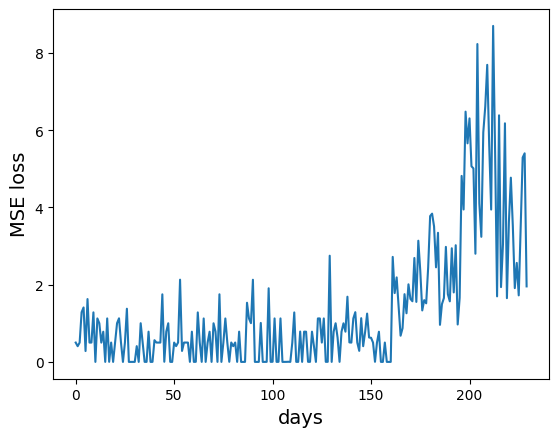

The folder  ' //Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/EDB0714/Model/Action/ ' exits, Please check!
<KerasTensor shape=(None, 4, 29), dtype=float32, sparse=False, name=keras_tensor_28>
<KerasTensor shape=(None, 29), dtype=float32, sparse=False, name=keras_tensor_31>
Epoch 1/470
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - binary_accuracy: 0.3583 - loss: 5.6338
Epoch 2/470
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - binary_accuracy: 0.3442 - loss: 2.2508
Epoch 3/470
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - binary_accuracy: 0.3750 - loss: 2.0882
Epoch 4/470
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.3760 - loss: 2.0765
Epoch 5/470
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.3677 - loss: 2.0905
Epoch 6/470
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.3760 - loss: 2.0481
Epoch 7/470
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.3512 - loss: 2.1082
Epoch 8/470
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.3676 

<Figure size 640x480 with 0 Axes>

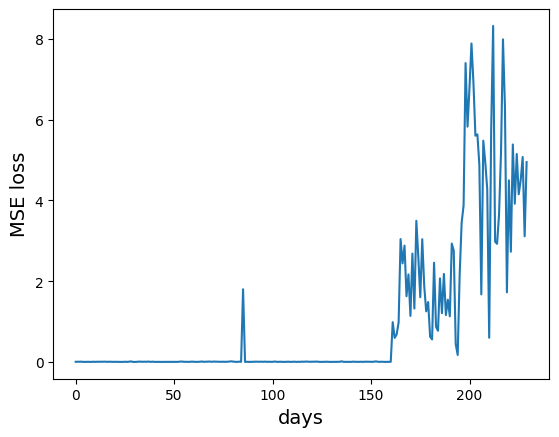

Create new folders: ' //Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/HXL0968/Model/Action/ ' successfully!
<KerasTensor shape=(None, 4, 33), dtype=float32, sparse=False, name=keras_tensor_40>
<KerasTensor shape=(None, 33), dtype=float32, sparse=False, name=keras_tensor_43>
Epoch 1/470
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - binary_accuracy: 0.4522 - loss: 5.0486
Epoch 2/470
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - binary_accuracy: 0.4234 - loss: 1.8897
Epoch 3/470
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.4252 - loss: 1.8392
Epoch 4/470
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - binary_accuracy: 0.4251 - loss: 1.8298
Epoch 5/470
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.4219 - loss: 1.9092
Epoch 6/470
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.4226 - loss: 1.8918
Epoch 7/470
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.4214 - loss: 1.9143
Epoch 8/470
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.4229

<Figure size 640x480 with 0 Axes>

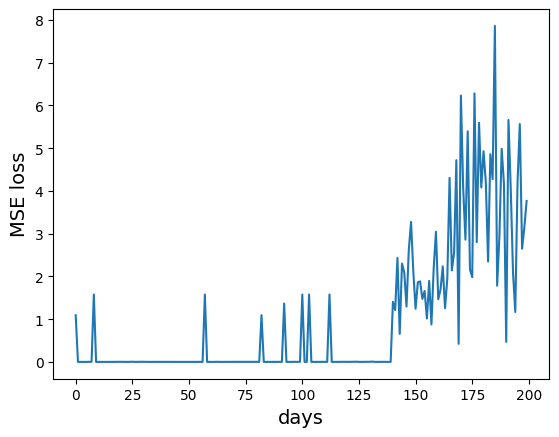

<Figure size 640x480 with 0 Axes>

In [ ]:
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Activation,Embedding,Conv2D,MaxPooling2D,Reshape,BatchNormalization,Dropout,Input,concatenate,GlobalAveragePooling2D,Flatten,ConvLSTM2D,LSTM,Conv3D
from tensorflow.keras.optimizers import Adam
import numpy as np
import linecache
import os
import tensorflow as tf
from keras import losses, metrics
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import warnings

def path_check(path):

    folders = os.path.exists(path)
    if not folders:
        print("Create new folders: ' %s ' successfully!" % (path))
        os.makedirs(path)
    else:
        print("The folder  ' %s ' exits, Please check!" % (path))
        pass

def train(files_train,labels_train,save_path,files_test,predict_save,action_length):
    """ Deep Learning model for users' actions
    # Params:
    ----
        files_train: training data (data for model training)
        labels_train: labels of training data
        save_path: the path of model that is going to be saved 
        files_test: test data 
        predict_save: the predicted labels of test data 
        action_length: the length of input data (include both training data and test data)
    """
    seq_length=4
    input_dims=seq_length*action_length
    # ---------------模型输入 (Model input)---------------
    x_train=np.loadtxt(files_train,delimiter=',')
    y_train=np.loadtxt(labels_train,delimiter=',')

    # ---------------模型结构 (model structure)--------------
    main_input=Input(shape=(input_dims,),dtype='float32',name='MainInput')
    Inputs=Reshape((seq_length,action_length))(main_input)
    print(Inputs)
    layer=LSTM(100,return_sequences=True,activation='tanh')(Inputs)
    layer=LSTM(160,return_sequences=False,activation='tanh')(layer)
    layer=Dense(action_length,activation='relu')(layer)
    print(layer)
    output=layer
    model=Model(inputs=main_input,outputs=output)
    model.compile(optimizer='adam',loss='mse',metrics=['binary_accuracy'])

    # ----------------- (model save)------------------
    tensorboard_path = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/' + USERNAME + '/Model/Action'
    # (visualization)
    tbCallback = TensorBoard(log_dir=tensorboard_path, histogram_freq=0, write_graph=True, write_images=True, embeddings_freq=0, embeddings_metadata=None)
    # (save the best model)
    checkpoint = ModelCheckpoint(save_path, monitor='loss', verbose=0, save_best_only='True')
    early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1)

    # ----------------- (training)--------------------
    model.fit(x_train, y_train, batch_size=6, epochs=470, shuffle=True, callbacks=[tbCallback, checkpoint, early_stopping])

    # ----------------- (prediction)---------------------
    x_test = np.loadtxt(files_test, delimiter=',')
    y_pred = model.predict(x_test)
    np.savetxt(predict_save, y_pred, fmt='%f', delimiter=',')

def test(files_test, save_path, predict_save):

    labels_name = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/' + username + '/feature/label_test.csv'
    x_test = np.loadtxt(files_test, delimiter=',')
    model = load_model(save_path)
    pred = model.predict(x_test)
    print(np.shape(pred))
    pred = np.where(pred > 0, pred, 0)
    np.savetxt(predict_save, pred, fmt='%f', delimiter=',')

def my_loss_forFeatures(label_test, predict_save, myloss_save, figure_save):
    y_true = np.loadtxt(label_test, delimiter=',')
    y_pred = np.loadtxt(predict_save, delimiter=',')
    batch_size = np.shape(y_pred)[0]
    All_loss = []
    for i in range(batch_size):
        mse = np.mean(np.square(y_pred[i] - y_true[i]))
        All_loss.append(mse)
    x_list = range(0, batch_size)
    np.savetxt(myloss_save, All_loss, fmt='%f', delimiter=',')
    plt.figure()
    plt.plot(x_list, All_loss)
    plt.show()
    plt.savefig(figure_save)
    print(np.shape(All_loss))

def Calculate_deviations(files_test, label_test, save_path, loss_save, figure_save, action_length):


    x_test = np.loadtxt(files_test, delimiter=',')
    y_test = np.loadtxt(label_test, delimiter=',')
    print(np.shape(x_test))
    print(np.shape([x_test[0]]))
    print(len(x_test))
    model = load_model(save_path)
    All_loss = []
    x_list = range(0, len(x_test))
    for i in range(len(x_test)):
        x_small_test = np.reshape(x_test[i], (1, 4 * action_length))
        y_small_test = np.reshape(y_test[i], (1, action_length))
        loss, acc = model.evaluate(x=x_small_test, y=y_small_test, verbose=0)
        All_loss.append(loss)
    np.savetxt(loss_save, All_loss, fmt='%f', delimiter=',')
    plt.figure()
    plt.plot(x_list, All_loss)
    plt.xlabel('days', fontsize=14)
    plt.ylabel('MSE loss', fontsize=14)
    plt.show()
    plt.savefig(figure_save)

if __name__ == "__main__":
    for username, length in user_max_length.items():
        USERNAME = username
        action_length = length

        folder = '//Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/' + USERNAME + '/Model/Action/'
        save_path = folder + 'model.keras'
        files_train = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/' + USERNAME + '/sequence/' + 'data_train.csv'
        labels_train = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/' + USERNAME + '/sequence/' + 'label_train.csv'
        files_test = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/' + USERNAME + '/sequence/' + 'data_test.csv'
        label_test = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/' + USERNAME + '/sequence/' + 'label_test.csv'
        predict_save = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/' + USERNAME + '/sequence/' + 'predict.csv'
        loss_save = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/' + USERNAME + '/sequence/' + 'loss.csv'
        figure_save = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/' + USERNAME + '/sequence/' + 'loss.jpg'
        path_check(folder)

        # ------------------------- (training )-------------------------
        train(files_train, labels_train, save_path, files_test, predict_save, action_length)

        # ---------------- calculate all deviations for all data (train+test)
        predict_save = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/' + USERNAME + '/sequence/' + 'predict_all.csv'
        files_all = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/' + USERNAME + '/sequence/' + 'data_all.csv'
        labels_all = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/' + USERNAME + '/sequence/' + 'label_all.csv'
        loss_save = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/' + USERNAME + '/sequence/' + 'loss_all.csv'
        figure_save = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/' + USERNAME + '/sequence/' + 'loss_all.jpg'

        Calculate_deviations(files_all, labels_all, save_path, loss_save, figure_save, action_length)


# Static Feature Training

automates the workflow of training, retraining, evaluating, and performing anomaly
detection on user behavioral data using a GRU model.

Constructs a GRU neural network
* Two GRU layers
* Dense layer

Uses the trained model to predict the future user behaviors/features.it computes the mean
squared error (MSE) for each sample/day and saves these values, which allows to see how
well the model matches actual user behavior.

**Detects Anomalies**: Applies a threshold-based approach to the daily MSE values, which
will be by flagging periods of sustained high error as potential anomalies (for example if
MSE remains above a calculated threshold for a set number of consecutive days)

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4405 - loss: 93.0025   
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5259 - loss: 61.7749
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5208 - loss: 49.4227
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5745 - loss: 39.4580
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5109 - loss: 37.6277
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6359 - loss: 33.7148
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5296 - loss: 35.1558
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4933 - loss: 34.4483
Epoch 9/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5649 - loss: 33.8293
Epoch 10/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5231 - loss: 32.1031
Epoch 11/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5736 - loss: 30.7869
Epoch 12/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accurac

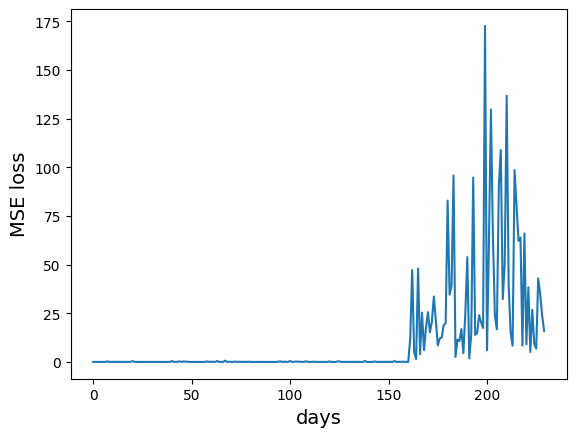

Anomaly detected for user TNM0961 starting from day: 201
Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.3464 - loss: 225.9327 
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4790 - loss: 154.5593
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4854 - loss: 115.3104
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4195 - loss: 90.0261    
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4588 - loss: 69.8425
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4735 - loss: 55.1793
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4927 - loss: 43.7080
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4702 - loss: 37.4758
Epoch 9/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4973 - loss: 30.4679
Epoch 10/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4380 - loss: 26.4913
Epoch 11/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3931 - loss: 23.751

<Figure size 640x480 with 0 Axes>

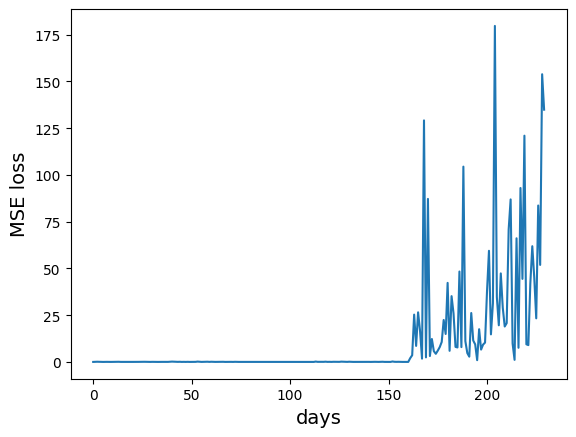

No anomaly detected for user EDB0714
Epoch 1/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6339 - loss: 63.8688
Epoch 2/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7509 - loss: 36.3395
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7420 - loss: 23.1355
Epoch 4/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7554 - loss: 19.3476
Epoch 5/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7932 - loss: 17.2921
Epoch 6/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7750 - loss: 15.9444
Epoch 7/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8020 - loss: 14.6800
Epoch 8/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7373 - loss: 15.2629
Epoch 9/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7697 - loss: 15.8579
Epoch 10/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7744 - loss: 16.0013
Epoch 11/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8111 - loss: 15.1719
Epoch 12/30
24/24 ━━━━━━━

<Figure size 640x480 with 0 Axes>

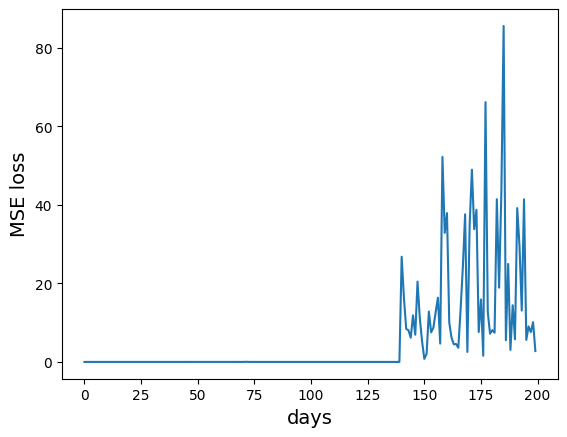

Anomaly detected for user HXL0968 starting from day: 158
Dictionary of user anomaly start days: {'TNM0961': 201, 'HXL0968': 158}


<Figure size 640x480 with 0 Axes>

In [ ]:
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Activation, Embedding, Conv2D, MaxPooling2D, Reshape, BatchNormalization, Dropout, Input, concatenate, GlobalAveragePooling2D, Flatten, GRU, Conv3D, ConvLSTM2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import linecache
import tensorflow as tf
import os
from keras import losses, metrics
from keras.callbacks import TensorBoard, ModelCheckpoint
import matplotlib.pyplot as plt

def path_check(path):
    folders = os.path.exists(path)
    if not folders:
        print("Create new folders: ' %s ' successfully!" % (path))
        os.makedirs(path)
    else:
        print("The folder  ' %s ' exits, Please check!" % (path))
        os._exit(0)

def count_line(files_in):
    file_open = open(files_in, 'r')
    count = 0
    for line in file_open:
        count += 1
    return count

def data_generator(files_name, num_days=5, batch_size=30):
    counts = count_line(files_name) - 1
    real_counts = counts - num_days + 1
    rounds = int(real_counts / batch_size)
    while (1):
        for i in range(rounds):
            data_batch = []
            label_batch = []
            for j in range(batch_size):
                data_index = i + j + 1
                label_index = data_index + 4
                data_one = linecache.getline(files_name, data_index).strip().split(',') + \
                           linecache.getline(files_name, data_index + 1).strip().split(',') + \
                           linecache.getline(files_name, data_index + 2).strip().split(',') + \
                           linecache.getline(files_name, data_index + 3).strip().split(',')
                labe_data = linecache.getline(files_name, label_index).strip().split(',')
                data_batch.append(data_one)
                label_batch.append(labe_data)
            data_batch = np.array(data_batch)
            label_batch = np.array(label_batch)
            data_out = np.reshape(data_batch, (batch_size, 192))
            label_out = np.reshape(label_batch, (batch_size, 48))
            i = i + batch_size + 1
            yield data_out, label_out

def train(files_train, labels_train, save_path, files_test, predict_save):
    x_train = np.loadtxt(files_train, delimiter=',')
    y_train = np.loadtxt(labels_train, delimiter=',')

    main_input = Input(shape=(148,), dtype='float32', name='MainInput')
    Inputs = Reshape((4, 37))(main_input)
    layer = GRU(100, return_sequences=True, activation='tanh')(Inputs)
    layer = GRU(160, return_sequences=False, activation='tanh')(layer)
    layer = Dense(37, activation='relu')(layer)
    output = layer
    model = Model(inputs=main_input, outputs=output)
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

    tensorboard_path = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/' + USERNAME + '/Model/Feature'
    tbCallback = TensorBoard(log_dir=tensorboard_path, histogram_freq=0, write_graph=True, write_images=True, embeddings_freq=0, embeddings_metadata=None)
    checkpoint = ModelCheckpoint(save_path, monitor='loss', verbose=0, save_best_only='True')
    model.fit(x_train, y_train, batch_size=6, epochs=30, shuffle=True, callbacks=[tbCallback, checkpoint])

    x_test = np.loadtxt(files_test, delimiter=',')
    y_pred = model.predict(x_test)
    np.savetxt(predict_save, y_pred, fmt='%f', delimiter=',')

def retrain(files_train, labels_train, save_path, files_test, predict_save):
    x_train = np.loadtxt(files_train, delimiter=',')
    y_train = np.loadtxt(labels_train, delimiter=',')
    model = load_model(save_path)

    tensorboard_path = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/' + USERNAME + '/Model/Feature'
    tbCallback = TensorBoard(log_dir=tensorboard_path, histogram_freq=0, write_graph=True, write_images=True, embeddings_freq=0, embeddings_metadata=None)
    checkpoint = ModelCheckpoint(save_path, monitor='loss', verbose=0, save_best_only='True')

    model.fit(x_train, y_train, batch_size=6, epochs=800, shuffle=True, callbacks=[tbCallback, checkpoint])

    x_test = np.loadtxt(files_test, delimiter=',')
    y_pred = model.predict(x_test)
    np.savetxt(predict_save, y_pred, fmt='%f', delimiter=',')

def test(files_test, save_path, predict_save):
    x_test = np.loadtxt(files_test, delimiter=',')
    model = load_model(save_path)
    pred = model.predict(x_test)
    pred = np.where(pred > 0.47, pred, 0)
    np.savetxt(predict_save, pred, fmt='%f', delimiter=',')
    return pred
def my_loss_forFeatures(label_test, predict_save, myloss_save, figure_save):
    y_true = np.loadtxt(label_test, delimiter=',')
    y_pred = np.loadtxt(predict_save, delimiter=',')
    batch_size = np.shape(y_pred)[0]
    All_loss = []
    for i in range(batch_size):
        mse = np.mean(np.square(y_pred[i] - y_true[i]))
        All_loss.append(mse)
    x_list = range(0, batch_size)
    np.savetxt(myloss_save, All_loss, fmt='%f', delimiter=',')


def Calculate_deviations(files_test, label_test, save_path, loss_save, figure_save):
    x_test = np.loadtxt(files_test, delimiter=',')
    y_test = np.loadtxt(label_test, delimiter=',')
    model = load_model(save_path)
    All_loss = []
    x_list = range(0, len(x_test))
    for i in range(len(x_test)):
        x_small_test = np.reshape(x_test[i], (1, 148))
        y_small_test = np.reshape(y_test[i], (1, 37))
        loss, acc = model.evaluate(x=x_small_test, y=y_small_test, verbose=0)
        All_loss.append(loss)
    np.savetxt(loss_save, All_loss, fmt='%f', delimiter=',')
    plt.figure()
    plt.plot(x_list, All_loss)
    plt.xlabel('days', fontsize=14)
    plt.ylabel('MSE loss', fontsize=14)
    plt.show()
    plt.savefig(figure_save)

def detect_anomaly_start(loss_values, threshold, consecutive_days):
    anomaly_start = None
    consecutive_count = 0
    for day, loss in enumerate(loss_values):
        if loss > threshold:
            consecutive_count += 1
            if consecutive_count >= consecutive_days:
                anomaly_start = day - consecutive_days + 1
                break
        else:
            consecutive_count = 0
    return anomaly_start

def calculate_threshold(loss_values, multiplier):
    mean_loss = np.mean(loss_values)
    std_loss = np.std(loss_values)
    threshold = mean_loss + multiplier * std_loss
    return threshold


def main():
    user_anomaly_start = {}  # Dictionary to store username and start of anomaly
    consecutive_days = 3  #Number of consecutive days with anomaly to start
    for username, length in user_max_length.items():
        USERNAME = username
        folder = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/' + USERNAME + '/Model/Feature/'
        save_path = folder + 'model.keras'
        files_train = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/' + USERNAME + '/feature/' + 'data_train.csv'
        labels_train = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/' + USERNAME + '/feature/' + 'label_train.csv'
        files_test = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/' + USERNAME + '/feature/' + 'data_test.csv'
        predict_save = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/' + USERNAME + '/feature/' + 'predict.csv'
        label_test = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/' + USERNAME + '/feature/' + 'label_test.csv'
        loss_save = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/' + USERNAME + '/feature/' + 'loss.csv'
        figure_save = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/' + USERNAME + '/feature/' + 'loss.jpg'
        figure_my_save = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/' + USERNAME + '/feature/' + 'myloss.jpg'
        myloss_save = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/' + USERNAME + '/feature/' + 'myloss.csv'

        train(files_train, labels_train, save_path, files_test, predict_save)
        retrain(files_train, labels_train, save_path, files_test, predict_save)

        # Calculate all deviations for all data (train+test)
        predict_save = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/' + USERNAME + '/feature/' + 'predict_all.csv'
        files_all = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/' + USERNAME + '/feature/' + 'data_all.csv'
        labels_all = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/' + USERNAME + '/feature/' + 'label_all.csv'
        loss_save = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/' + USERNAME + '/feature/' + 'loss_all.csv'
        figure_save = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/' + USERNAME + '/feature/' + 'loss_all.jpg'
        figure_my_save = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/' + USERNAME + '/feature/' + 'myloss_all.jpg'
        myloss_save = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/' + USERNAME + '/feature/' + 'myloss_all.csv'

        test(files_all, save_path, predict_save)
        Calculate_deviations(files_all, labels_all, save_path, loss_save, figure_save)
        my_loss_forFeatures(labels_all, predict_save, myloss_save, figure_my_save)
        #Calculate the threshold and detect the start of the anomaly
        loss_values = np.loadtxt(loss_save, delimiter=',')
        multiplier = 2  # Adjust this multiplier based on your tolerance for false positives
        threshold = calculate_threshold(loss_values, multiplier)
        anomaly_start = detect_anomaly_start(loss_values, threshold, consecutive_days)

        if anomaly_start is not None:
            print("Anomaly detected for user", username, "starting from day:", anomaly_start)
            user_anomaly_start[username] = anomaly_start
        else:
            print("No anomaly detected for user", username)

    return user_anomaly_start

if __name__ == "__main__":
    user_anomaly_start = main()
    print("Dictionary of user anomaly start days:", user_anomaly_start)


# Role Feature and Mix

Calculates deviation metrics (losses) from expected behavior, Combines multiple sources
of these losses, generates anomaly labels, and aggregates everything to provide a good
view of user behavior deviations over time

Calculates Daily Deviations: For each user, it computes the mean squared error (MSE)
between their daily features and the global role feature.

Generates Labels Based on Anomaly Detection: Using a previously determined anomaly
start day (stored in a dictionary), the script labels each day (e.g., days before the anomaly
vs. after) by writing corresponding binary labels to a file.

Finally, it merges the combined loss files and label files from all users into a single dataset 

(230,)


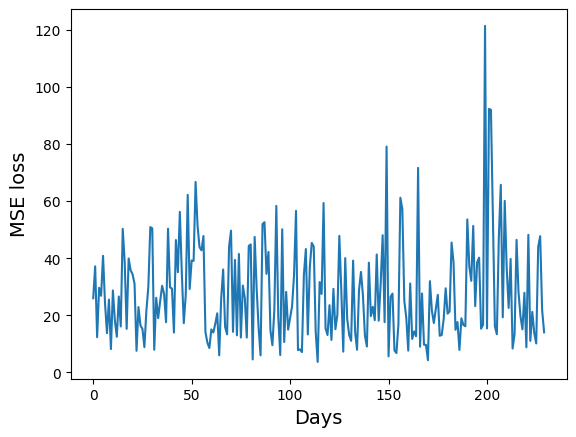

(230,)


<Figure size 640x480 with 0 Axes>

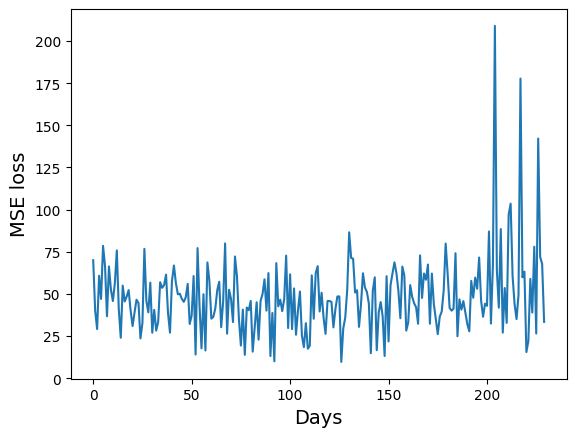

(200,)


<Figure size 640x480 with 0 Axes>

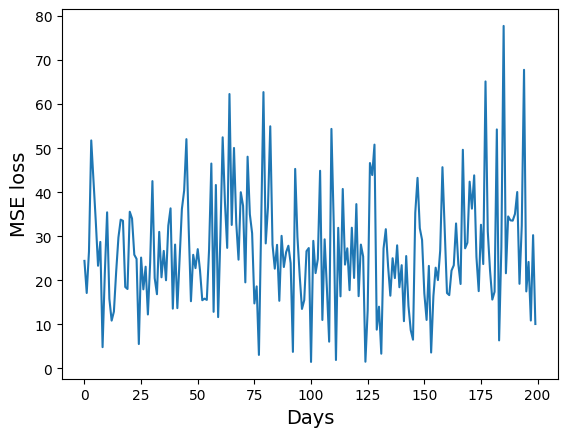

Create new folders: '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/TNM0961/Mix' successfully!
(230, 1)
(230, 3)
Create new folders: '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/EDB0714/Mix' successfully!
(230, 1)
(230, 3)
Create new folders: '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/HXL0968/Mix' successfully!
(200, 1)
(200, 3)
Create new folders: '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/Mix' successfully!


<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import linecache
import matplotlib.pyplot as plt
import os

def path_check(path):

    folders = os.path.exists(path)
    if not folders:
        print("Create new folders: '%s' successfully!" % (path))
        os.makedirs(path)
    else:
        print("The folder '%s' exists, Please check!" % (path))
        pass

def role_feature():
    base_path = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data'
    file_name = 'feature/data_out.csv'  # remove the leading slash
    user_names 
    All_users_features = np.zeros((37))
    for username in user_names:
        # Build the full file path
        full_path = os.path.join(base_path, username, file_name)
        if not os.path.exists(full_path):
            print(f"Error: {full_path} does not exist.")
            continue
        All_features = np.loadtxt(full_path, delimiter=',')
        Nums = len(All_features)
        Aver_features = np.zeros((37))
        for matrix in All_features:
            Aver_features += matrix
        Aver_features /= Nums
        All_users_features += Aver_features
    role_features = All_users_features / len(user_names)
    role_features = role_features.reshape(1, 37)
    save_path = os.path.join(base_path, 'Role_feature.csv')
    np.savetxt(save_path, role_features, delimiter=',', fmt='%f')
def deviations_for_users(username):
    '''
Calculate the mean square error (MSE) between the user's daily functionality and the role functionality.    '''
    file_name = '/feature/label_all.csv'
    role_feature_file = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/' + 'Role_feature.csv'
    Role_features = np.loadtxt(role_feature_file, delimiter=',')
    user_features = np.loadtxt('/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/' + username + file_name, delimiter=',')
    All_loss = []
    for matrix in user_features:
        squared_differences = np.square(Role_features - matrix)
        mse = squared_differences.mean()
        All_loss.append(mse)
    np.savetxt('/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/' + username + '/Model/Role_loss.csv', All_loss, delimiter=',', fmt='%f')
    x_list = range(0, len(user_features))
    print(np.shape(All_loss))
    plt.figure()
    plt.plot(x_list, All_loss)
    plt.xlabel('Days', fontsize=14)
    plt.ylabel('MSE loss', fontsize=14)
    plt.show()
    plt.savefig('/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/' + username + '/Model/Role_features.jpg')


def count_line(files_in):
    file_open = open(files_in, 'r')
    count = 0
    for line in file_open:
        count += 1
    file_open.close()
    return count

if __name__ == "__main__":
    # ----- 1   role features
        
    role_feature()  # Generate Role_feature.csv first.

    for user in user_names:
        deviations_for_users(user)
    # ------ 2  (mix data)------
    for username in user_names:
        user_path = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/' + username + '/Mix'
        path_check(user_path)
        file_feature = '/feature/myloss_all.csv'
        file_sequence = '/sequence/loss_all.csv'
        file_role = '/Model/Role_loss.csv'
        file_save = user_path + '/Mix_loss.csv'
        # Load the loss of each feature
        feature_loss = np.loadtxt('/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/' + username + file_feature, delimiter=',')
        sequence_loss = np.loadtxt('/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/' + username + file_sequence, delimiter=',')
        role_loss = np.loadtxt('/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/' + username + file_role, delimiter=',')

        # Adjust dimensions to fit
        min_length = min(len(feature_loss), len(sequence_loss), len(role_loss))
        feature_loss = feature_loss[:min_length]
        sequence_loss = sequence_loss[:min_length]
        role_loss = role_loss[:min_length]

        feature_loss = np.reshape(feature_loss, (len(feature_loss), 1))
        sequence_loss = np.reshape(sequence_loss, (len(sequence_loss), 1))
        role_loss = np.reshape(role_loss, (len(role_loss), 1))

        mix_loss = np.concatenate((feature_loss, sequence_loss, role_loss), axis=1)
        np.savetxt(file_save, mix_loss, delimiter=',', fmt='%f')
        print(np.shape(role_loss))
        print(np.shape(mix_loss))
        # ----- 3 Generate the label based on the source data
    for username, nums in user_anomaly_start.items():
        user_path = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/' + username + '/Mix'
        file_save = user_path + '/label_loss.csv'
        file_read = user_path + '/Mix_loss.csv'
        Num_lines = count_line(file_read)
        fileopen = open(file_save, 'wt')
        index = 0
        while index < Num_lines:
            if index < nums - 1:
                fileopen.writelines('0,1\n')
            else:
                fileopen.writelines('1,0\n')
            index = index + 1
        fileopen.close()
    # -------- 4 (mix all data) --------
    mix_path = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/Mix'
    path_check(mix_path)
    file_save = open(mix_path + '/Mix_all_loss.csv', 'wt')
    label_save = open(mix_path + '/Mix_all_label.csv', 'wt')
    for username in user_anomaly_start:
        user_path = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/' + username + '/Mix'
        mix_loss = user_path + '/Mix_loss.csv'
        mix_label = user_path + '/label_loss.csv'
        loss_open = open(mix_loss, 'r')
        label_open = open(mix_label, 'r')
        for line in loss_open:
            file_save.writelines(line)
        loss_open.close()
        for line in label_open:
            label_save.writelines(line)
        label_open.close()


    # exit(0)

    

# Mix Data for MLP

Here it Ensures that the dataset will be randomized to avoid ordering bias

After shuGling, the code divides the randomized data into 3 subsets based on specified
proportions which are 70% for training, 15% for validation and test

In [ ]:
import linecache
import random

def count_line(files_in):
    with open(files_in, 'r') as file_open:
        count = sum(1 for _ in file_open)
    return count

def Random_Num(index, number):
    '''
Generate a list of indexes from random indexes
index: the file index
number: the length of the generated list
return: a list of indexes
    '''
    return random.sample(list(index), number)

def train_test_val_generate(data_all, label_all, train_data_save, train_label_save, val_data_save, val_label_save, test_data_save, test_label_save, train_rate=0.7, val_rate=0.15):
    '''
Extract the "train_rate" percentage data for training, the "val_rate" percentage for validation, and the rest for testing.    '''

    data_in = open(data_all, 'r')
    label_in = open(label_all, 'r')
    data_train = open(train_data_save, 'wt')
    data_val = open(val_data_save, 'wt')
    data_test = open(test_data_save, 'wt')
    label_train = open(train_label_save, 'wt')
    label_val = open(val_label_save, 'wt')
    label_test = open(test_label_save, 'wt')

    data_num = count_line(data_all)
    train_num = int(data_num * train_rate)
    val_num = int(data_num * val_rate)
    test_num = data_num - train_num - val_num
    print(f"Train: {train_num}, Validation: {val_num}, Test: {test_num}")

    index = 0
    for line in data_in:
        if index < train_num:
            data_train.writelines(line)
        elif index < train_num + val_num:
            data_val.writelines(line)
        else:
            data_test.writelines(line)
        index += 1

    data_train.close()
    data_val.close()
    data_test.close()

    index = 0
    for label in label_in:
        if index < train_num:
            label_train.writelines(label)
        elif index < train_num + val_num:
            label_val.writelines(label)
        else:
            label_test.writelines(label)
        index += 1

    label_train.close()
    label_val.close()
    label_test.close()
    data_in.close()
    label_in.close()


if __name__ == "__main__":
    working_folder = 'Data/Mix/'
    # ----- disorder all mixed data ------
    file_open = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/Mix/' + 'Mix_all_loss.csv'
    label_open = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/Mix/' + 'Mix_all_label.csv'
    file_save = open('/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/Mix/' + 'Disorder_loss.csv', 'wt')
    label_save = open('/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/Mix/' + 'Disorder_label.csv', 'wt')
    line_counts = count_line(label_open)
    index = [n for n in range(0, line_counts)]
    Random_index = Random_Num(index, line_counts)
    print(Random_index)
    for num in Random_index:
        line = linecache.getline(file_open, num + 1)
        label = linecache.getline(label_open, num + 1)
        file_save.writelines(line)
        label_save.writelines(label)
    file_save.close()
    label_save.close()

    # --------- generate train, validation, AND test data for MLP
    data_all = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/Mix/' + 'Disorder_loss.csv'
    label_all = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/Mix/' + 'Disorder_label.csv'
    data_train = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/Mix/' + 'train.csv'
    label_train = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/Mix/' + 'label_train.csv'
    data_val = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/Mix/' + 'val.csv'
    label_val = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/Mix/' + 'label_val.csv'
    data_test = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/Mix/' + 'test.csv'
    label_test = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/Mix/' + 'label_test.csv'

    train_test_val_generate(data_all, label_all, data_train, label_train, data_val, label_val, data_test, label_test, train_rate=0.7, val_rate=0.15)


[413, 77, 150, 321, 85, 366, 314, 44, 53, 60, 329, 156, 398, 101, 187, 396, 207, 49, 211, 280, 343, 382, 137, 179, 169, 289, 427, 404, 362, 281, 353, 304, 201, 283, 161, 158, 253, 41, 171, 301, 32, 250, 222, 418, 39, 246, 240, 104, 212, 313, 348, 136, 385, 365, 346, 336, 360, 386, 93, 111, 333, 191, 414, 117, 252, 265, 149, 4, 273, 163, 423, 194, 95, 81, 119, 182, 87, 47, 144, 303, 224, 173, 219, 115, 121, 154, 61, 155, 243, 62, 356, 347, 255, 403, 247, 285, 34, 291, 249, 73, 264, 359, 260, 203, 286, 221, 271, 100, 40, 339, 65, 184, 74, 381, 18, 82, 344, 45, 327, 190, 99, 202, 326, 384, 311, 185, 145, 90, 310, 272, 59, 83, 160, 66, 407, 98, 270, 168, 225, 147, 140, 307, 373, 241, 233, 199, 57, 12, 338, 52, 139, 188, 164, 14, 204, 315, 113, 128, 193, 109, 97, 354, 337, 393, 397, 107, 290, 43, 350, 189, 267, 56, 276, 306, 70, 33, 391, 287, 64, 152, 312, 72, 17, 262, 68, 279, 405, 278, 330, 2, 7, 122, 367, 342, 248, 349, 3, 334, 88, 237, 135, 392, 309, 417, 165, 5, 21, 372, 328, 298, 424,

# MLP Training and Metrics

Here it sets up an end-to-end process (from data normalization, model training, and
hyperparameter tuning, to detailed performance evaluation) for a binary classification task
using an MLP (Multilayer perceptron).

* An MLP is built with dense layers including batch normalization and a final softmax
output layer for two classes
* After training, the model is evaluated on test data

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - binary_accuracy: 0.7792 - loss: 0.6481 - val_binary_accuracy: 0.9180 - val_loss: 0.6225 - learning_rate: 0.0010
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.7965 - loss: 0.6027 - val_binary_accuracy: 0.9344 - val_loss: 0.5938 - learning_rate: 0.0010
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.8616 - loss: 0.5279 - val_binary_accuracy: 0.9344 - val_loss: 0.5736 - learning_rate: 0.0010
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.8565 - loss: 0.5150 - val_binary_accuracy: 0.9180 - val_loss: 0.5542 - learning_rate: 0.0010
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.8875 - loss: 0.4826 - val_binary_accuracy: 0.9016 - val_loss: 0.5398 - learning_rate: 0.0010
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - binary_accuracy: 0.8540 - loss: 0.5097 - val_binary_accuracy: 0.9016 - val_loss: 0.5286 - learning_rate: 0.0010
Epoch 7/100
8/8 ━━━━

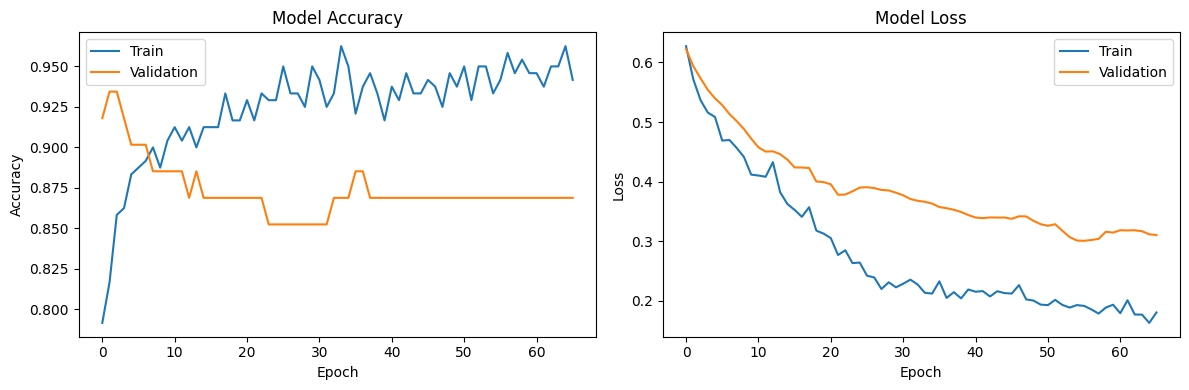

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Test Accuracy: 0.892307698726654
Matrice de confusion:
 [[ 4  6]
 [ 1 54]]


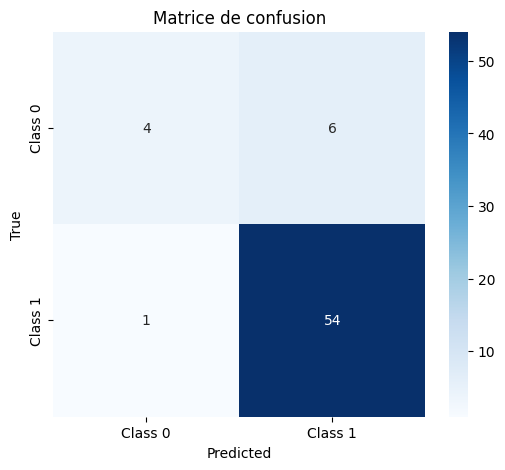

True Positives: 54 (83.08%)
True Negatives: 4 (6.15%)
False Positives: 6 (9.23%)
False Negatives: 1 (1.54%)
Précision: 0.9
Rappel: 0.9818181818181818
F1-score: 0.9391304347826087


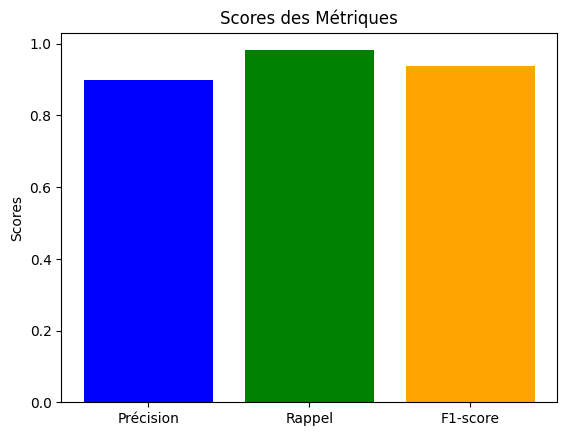

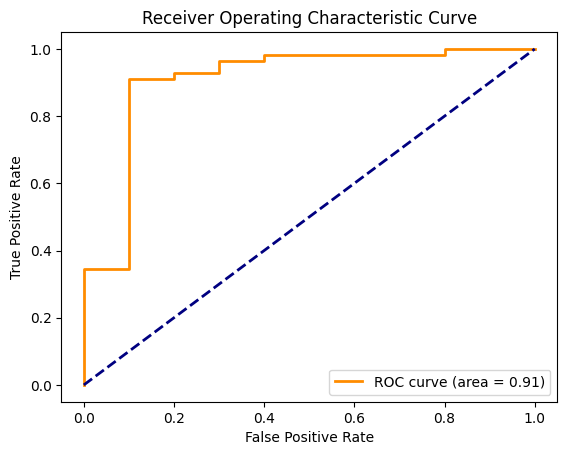

Nombre_normal:  55  nombre_anormal:  10
Drn:  54  Dra:  4
0.8923076923076924


In [ ]:
from keras.models import Model
from keras.layers import Dense, BatchNormalization, Dropout, Input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import numpy as np
import linecache
import matplotlib.pyplot as plt
import csv
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import seaborn as sns

def count_line(files_in):
    with open(files_in, 'r') as file_open:
        count = sum(1 for _ in file_open)
    return count

def plot_metrics(precision, recall, f1score):
    labels = ['Précision', 'Rappel', 'F1-score']
    values = [precision, recall, f1score]
    plt.bar(labels, values, color=['blue', 'green', 'orange'])
    plt.ylabel('Scores')
    plt.title('Scores des Métriques')
    plt.show()

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['binary_accuracy'], label='Train')
    plt.plot(history.history['val_binary_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

def train(files_train, labels_train, model_path, files_test, label_test, predict_save):
    # Load training data
    x_train = np.loadtxt(files_train, delimiter=',')
    y_train = np.loadtxt(labels_train, delimiter=',')

    # Normalize data
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)

    # Model architecture
    main_input = Input(shape=(x_train.shape[1],), dtype='float32', name='MainInput')
    layer = Dense(64, activation='relu')(main_input)
    layer = BatchNormalization()(layer)
    layer = Dense(32, activation='relu')(layer)
    layer = BatchNormalization()(layer)
    layer = Dense(2, activation='softmax')(layer)

    model = Model(inputs=main_input, outputs=layer)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['binary_accuracy'])

    # Callbacks
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model
    history = model.fit(x_train, y_train, batch_size=32, epochs=100, validation_split=0.2, shuffle=True, verbose=1, callbacks=[reduce_lr, early_stopping])

    # Plot the loss and accuracy curves
    plot_training_history(history)

    # Evaluate the model on the test data
    x_test = np.loadtxt(files_test, delimiter=',')
    y_test = np.loadtxt(label_test, delimiter=',')
    x_test = scaler.transform(x_test)
    y_pred = model.predict(x_test)
    np.savetxt(predict_save, y_pred, fmt='%f', delimiter=',')
    loss, acc = model.evaluate(x_test, y_test, verbose=0)
    print("Test Accuracy:", acc)

    # Compute binary predictions
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Generate the confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    print("Matrice de confusion:\n", cm)

    # Plot the confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('confusion matrix')
    plt.show()
      # Calculate false positives and false negatives
    FP = cm[0, 1]
    FN = cm[1, 0]
    total = np.sum(cm)
    FP_percent = FP / total * 100
    FN_percent = FN / total * 100
    TP = cm[1, 1]
    TN = cm[0, 0]
    TP_percent = TP / total * 100
    TN_percent = TN / total * 100

    print(f"True Positives: {TP} ({TP_percent:.2f}%)")
    print(f"True Negatives: {TN} ({TN_percent:.2f}%)")

    print(f"False Positives: {FP} ({FP_percent:.2f}%)")
    print(f"False Negatives: {FN} ({FN_percent:.2f}%)")


    # Calculate precision, recall and F1 scores
    precision = precision_score(y_true_classes, y_pred_classes)
    recall = recall_score(y_true_classes, y_pred_classes)
    f1score = f1_score(y_true_classes, y_pred_classes)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1score)

    plot_metrics(precision, recall, f1score)

    # Calculate the ROC curve
    fpr, tpr, _ = roc_curve(y_true_classes, y_pred[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()

    return y_train

def Calculatte(pred_file, label_file):
    file_label = open(label_file, 'r')
    Drn = 0
    Dra = 0
    with open(pred_file, 'r') as csvfile:
        reader = csv.reader(csvfile)
        for i, rows in enumerate(reader):
            Pred = int(rows[0])
            line = linecache.getline(label_file, i + 1)
            Label = int(line[0])
            if (Label == 0 and Pred == 0):
                Drn += 1
            if (Label == 1 and Pred == 1):
                Dra += 1
    print('Drn: ', Drn, ' Dra: ', Dra)
    return Dra + Drn

def Count_nor_ano(label):
    Num_nor = 0
    Num_ano = 0
    with open(label, 'r') as csvfile:
        reader = csv.reader(csvfile)
        for i, rows in enumerate(reader):
            if int(rows[0]) == 0:
                Num_nor += 1
            if int(rows[0]) == 1:
                Num_ano += 1
    print('Normal_Number: ', Num_nor, ' Abnormal_Number: ', Num_ano)
    return Num_ano + Num_nor

if __name__ == "__main__":
    working_folder = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/Mix/'
    files_train = working_folder + 'train.csv'
    labels_train = working_folder + 'label_train.csv'
    model_path = working_folder + 'MLP.h5'
    files_test = working_folder + 'test.csv'
    label_test = working_folder + 'label_test.csv'
    predict_save = working_folder + 'predict.csv'
    predict_label = working_folder + 'predict_label.csv'

    # Train the model
    train(files_train, labels_train, model_path, files_test, label_test, predict_save)

    # Add predictions to the data
    predicts = np.loadtxt(predict_save, delimiter=',')
    pred = np.where(predicts > 0.5, 1, 0)
    np.savetxt(predict_label, pred, delimiter=',', fmt='%d')

    # Calculate metrics
    all_label = Count_nor_ano(label_test)
    pred = Calculatte(predict_label, label_test)
    print(pred / all_label)
